# LR Analysis

This notebook analyze the LR properties of a system starting from the coupling matrix, transition quantities and the energies of the virtual orbitals

In [1]:
%autosave 0
from BigDFT import Logfiles as lf
from BigDFT import DoS as D
from futile import Yaml
from futile.Utils import write
#import matplotlib
#matplotlib.use('GTKAgg') 
import matplotlib.pyplot as plt
import numpy as np
import LRTDDFT as LR
HaeV=27.21138386

Autosave disabled


In [2]:
def build_syst_dict(systPath,norb):
    syst = {}
    outp = systPath+'linear-response/log'
    %cd $outp
    logs = !ls log-Rmult_*
    for l in logs:
        data = lf.Logfile(l)
        rmult = data.log['dft']['rmult'][0]
        nvirt = len(data.evals[0][0]) - norb
        syst[rmult] = {'nvirt':nvirt}
    %cd ../../../../
    return syst
    
def get_tddft_quantities(syst,sysPath):
    from futile.Utils import write
    outp = sysPath+'linear-response/log'
    %cd $outp
    for rVal in syst:
        dpath = 'data-'+'Rmult_'+str(rVal)+'/transition_quantities.txt'
        trans = np.loadtxt(dpath)
        syst[rVal]['T']=trans
        cpath = 'data-'+'Rmult_'+str(rVal)+'/coupling_matrix.txt'
        Cmat = np.loadtxt(cpath)
        syst[rVal]['C']=Cmat
        write('Casida Matrix is symmetric',np.allclose(Cmat,Cmat.T,atol=1.e-12))
        syst[rVal]['logfile'] = lf.Logfile('log-Rmult_'+str(rVal)+'_numVirt_'+str(syst[rVal]['nvirt'])+'.yaml')
    %cd ../../../../

## Analysis of $CO$

In [3]:
norbCO = 5
pathCO = 'CO/free-bc/'
CO = build_syst_dict(pathCO, norbCO)
naSmall = [16,64,96,160]
CO

/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/CO/free-bc/linear-response/log
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY


{7.0: {'nvirt': 280}, 9.0: {'nvirt': 280}, 10.0: {'nvirt': 280}}

In [4]:
reload(LR)
get_tddft_quantities(CO,pathCO)

/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/CO/free-bc/linear-response/log
Casida Matrix is symmetric True
Casida Matrix is symmetric True
Casida Matrix is symmetric True
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY


Chose the value of nalpha that give the same maximum energy in all the box

In [5]:
nalphaEmax = {}
rVals = CO.keys()
rVals.sort()
eMax = CO[rVals[-1]]['logfile'].evals[0][0][-1]
nalphaEmax[rVals[-1]] = len(CO[rVals[-1]]['logfile'].evals[0][0])-norbCO
print 'max sampled energy = ', HaeV*eMax
for r in rVals[0:len(rVals)-1][::-1]:
    na = 0
    em = 0
    while(em<eMax):
        na+=1
        em= CO[r]['logfile'].evals[0][0][norbCO+na]
    nalphaEmax[r] = na
nalphaEmax

max sampled energy =  14.7769179033


{7.0: 98, 9.0: 185, 10.0: 280}

In [7]:
# Activate this if the result for the highest number of nalpha is needed
nalphaEmax = {7.0:280,9.0:280,10.0:280}
nalphaEmax

{7.0: 280, 9.0: 280, 10.0: 280}

In [8]:
reload(LR)
LR.diagonalize_CM(norbCO,CO,naSmall,nalphaEmax)
LR.collect_LR(CO)

Solve for rVal =  9.0
Eigensystem solved for 16
Eigensystem solved for 64
Eigensystem solved for 96
Eigensystem solved for 160
Eigensystem solved for 280
Solve for rVal =  10.0
Eigensystem solved for 16
Eigensystem solved for 64
Eigensystem solved for 96
Eigensystem solved for 160
Eigensystem solved for 280
Solve for rVal =  7.0
Eigensystem solved for 16
Eigensystem solved for 64
Eigensystem solved for 96
Eigensystem solved for 160
Eigensystem solved for 280


In [9]:
CO[7.0]['eigenproblems'][16].keys()

['eigenvectors',
 'alpha_xyz',
 'oscillator_strengths',
 'Cmat',
 'eigenvalues',
 'transitions',
 'oscillator_strength_avg']

### Statical polarizability

Plot the convergence of the statical polarizability in the various box

In [9]:
CO_alpha_ref = {'alphaX':13.235,'alphaY':13.235,'alphaZ':18.728}

In [10]:
reload(LR)
alpha_CO = LR.collect_Alpha(CO,norbCO)

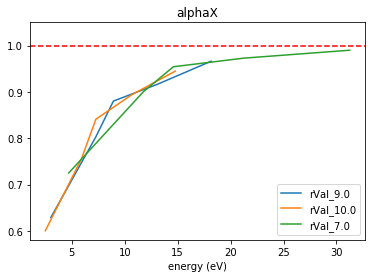

In [11]:
%matplotlib inline
component = 'alphaX'
for rVal in alpha_CO:
    val = np.array(alpha_CO[rVal][component])/CO_alpha_ref[component]
    plt.plot(alpha_CO[rVal]['naEnergy'],val,label='rVal_'+str(rVal))
plt.legend(loc='best')
plt.xlabel('energy (eV)')
plt.axhline(y=1.0, color='r', linestyle='--')
plt.title(component)
plt.ylim(ymax=1.05)
plt.show()

### Dynamical polarizability

In [12]:
reload(LR)
CO_spectrum = LR.collect_spectrum(CO)

Compute for rVal =  9.0  with nalpha =  280
numpoint =  336  omegaMax (eV) =  45.8183849825
Compute for rVal =  10.0  with nalpha =  280
numpoint =  311  omegaMax (eV) =  42.431982253
Compute for rVal =  7.0  with nalpha =  280
numpoint =  434  omegaMax (eV) =  59.1066901023


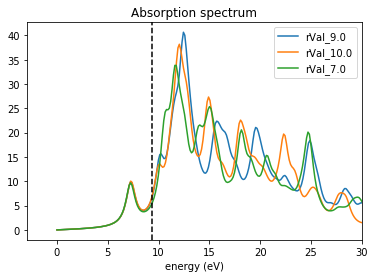

In [13]:
%matplotlib inline
syst = CO_spectrum
for rVal in syst:
    plt.plot(syst[rVal]['omega'],syst[rVal]['imagPart'],label='rVal_'+str(rVal))
plt.xlim(xmax=30)
plt.legend(loc='best')
plt.xlabel('energy (eV)')
plt.title('Absorption spectrum')
eps_h = abs(HaeV*LR.get_alpha_energy(CO[7.0]['logfile'],norbCO,0))
plt.axvline(x=eps_h, color='black', linestyle='--')
plt.show()

### Excitations

We add the threshold key to the dictionary (for the first numExc excitations)

In [14]:
reload(LR)
numExc = 900
LR.collect_excitation_thr(CO,norbCO,numExc,1e-2)

In [15]:
for rVal in CO:
    nalpha = CO[rVal]['eigenproblems'].keys()
    nalpha.sort()
    nvirt = nalpha[-1]
    maxEng = HaeV*np.sqrt(CO[rVal]['eigenproblems'][nvirt]['eigenvalues'][numExc-1]) 
    print 'maxEng for rval_', rVal, ' = ', maxEng

maxEng for rval_ 9.0  =  21.8861125506
maxEng for rval_ 10.0  =  19.8924830183
maxEng for rval_ 7.0  =  28.7012215799


We plot the excitations landscape in the different box

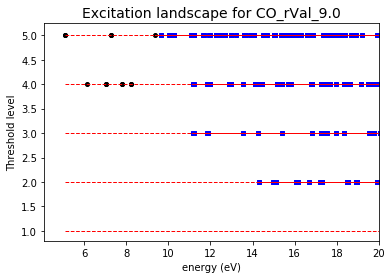

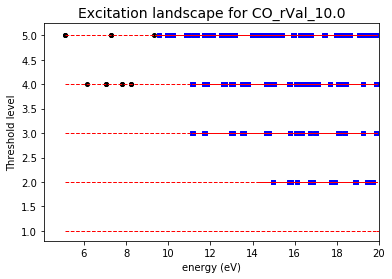

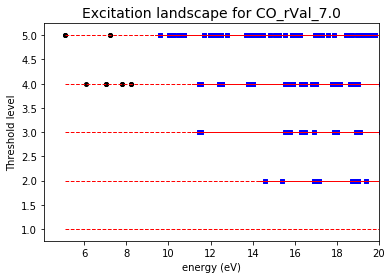

In [16]:
for rVal in CO:
    nalpha = CO[rVal]['eigenproblems'].keys()
    nalpha.sort()
    nvirt = nalpha[-1]
    syst = CO[rVal]['eigenproblems'][nvirt]
    pEng = LR.get_p_energy(CO[rVal]['logfile'],norbCO)

    Emin = HaeV*np.sqrt(syst['eigenvalues'][0])
    Emax = HaeV*np.sqrt(syst['eigenvalues'][numExc-1])

    for ind,p in enumerate(pEng):
        plt.plot((Emin,HaeV*abs(p)),(ind+1,ind+1),'--',c='red',linewidth=1)
        plt.plot((HaeV*abs(p),Emax),(ind+1,ind+1),'-',c='red',linewidth=1)
    
    for exc in range(numExc):
        eng = HaeV*np.sqrt(syst['eigenvalues'][exc])
        thind = syst['thresholds'][exc][0]
        th = HaeV*syst['thresholds'][exc][1]
        if eng < th : 
            plt.scatter(eng,thind,s=16,marker='o',c='black')
        else :
            plt.scatter(eng,thind,s=14,marker='s',c='blue')
    plt.title('Excitation landscape for CO_rVal_'+str(rVal),size=14) 
    plt.xlabel('energy (eV)')
    plt.ylabel('Threshold level')
    plt.xlim(xmin=Emin-1,xmax=20)#Emax)
    plt.show()

We plot the dos (of a given channel) comparing the results of different box

In [17]:
reload(LR)
channels = LR.collect_channels(CO,norbCO,numExc)

/usr/local/lib/python2.7/dist-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


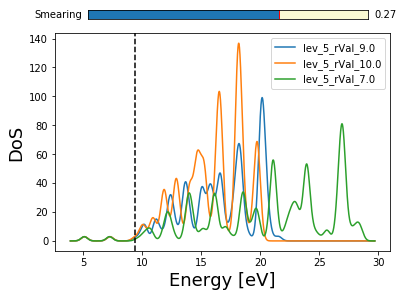

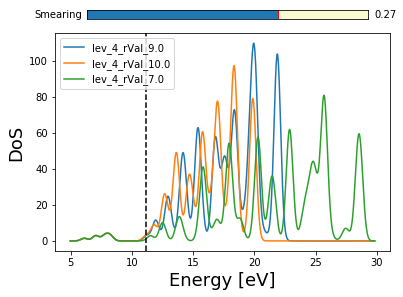

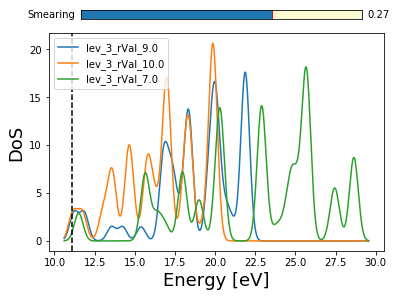

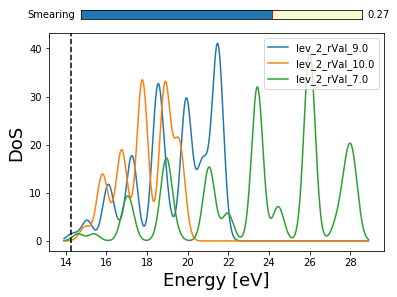

In [18]:
%matplotlib inline
levels = [5,4,3,2]
for l in levels:
    fe = HaeV*abs(LR.get_p_energy(CO[7.0]['logfile'],norbCO)[l-1])
    dos=D.DoS(fermi_level=fe)
    for rVal in channels:
        dos.append(energies=np.array([channels[rVal][l-1]]),label='lev_'+str(l)+'_rVal_'+str(rVal))
    dos.plot(sigma=0.01*HaeV)

These plots evidence the box independence of the excitations below threshold

As a final analysis we repeat the calculation of dynamical polarizability separing the contributions due to excitations above and below threshold 

In [19]:
reload(LR)
CO_spectrum_bt,CO_spectrum_at = LR.collect_spectrum_bt_at(CO)

numpoint =  160  omegaMax (eV) =  21.8861125506
numpoint =  160  omegaMax (eV) =  21.8861125506
numpoint =  146  omegaMax (eV) =  19.8924830183
numpoint =  146  omegaMax (eV) =  19.8924830183
numpoint =  210  omegaMax (eV) =  28.7012215799
numpoint =  210  omegaMax (eV) =  28.7012215799


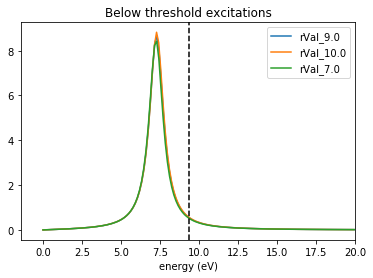

In [20]:
%matplotlib inline
syst = CO_spectrum_bt
for rVal in syst:
    plt.plot(syst[rVal]['omega'],syst[rVal]['imagPart'],label='rVal_'+str(rVal))
plt.xlim(xmax=20)
plt.legend(loc='best')
plt.xlabel('energy (eV)')
plt.title('Below threshold excitations')
eps_h = abs(HaeV*LR.get_alpha_energy(CO[7.0]['logfile'],norbCO,0))
plt.axvline(x=eps_h, color='black', linestyle='--')
plt.show()

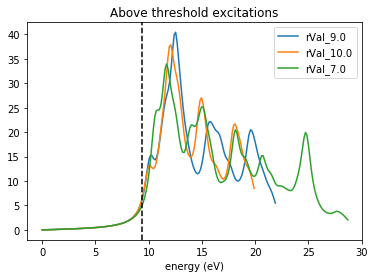

In [21]:
%matplotlib inline
syst = CO_spectrum_at
for rVal in syst:
    plt.plot(syst[rVal]['omega'],syst[rVal]['imagPart'],label='rVal_'+str(rVal))
plt.xlim(xmax=30)
plt.legend(loc='best')
plt.xlabel('energy (eV)')
plt.title('Above threshold excitations')
eps_h = abs(HaeV*LR.get_alpha_energy(CO[7.0]['logfile'],norbCO,0))
plt.axvline(x=eps_h, color='black', linestyle='--')
plt.show()

Detailed analysis of the excitations channels

In [22]:
print HaeV*LR.get_p_energy(CO[7.0]['logfile'],norbCO)
print HaeV*LR.get_p_energy(CO[9.0]['logfile'],norbCO)
print HaeV*LR.get_p_energy(CO[10.0]['logfile'],norbCO)

[-27.65494303 -14.24083585 -11.117007   -11.11700672  -9.36639558]
[-27.65506619 -14.24095328 -11.11712157 -11.11712129  -9.36652264]
[-27.65506692 -14.24095398 -11.11712224 -11.11712197  -9.36652341]


In [23]:
ch = 4
print 'th energy', HaeV*abs(LR.get_p_energy(CO[7.0]['logfile'],norbCO)[ch])
for a,b,c in zip(channels[7.0][ch][0:10],channels[9.0][ch][0:10],channels[10.0][ch][0:10]):
    print a,b,c

th energy 9.366395583
5.09541871994 5.11113483244 5.11657407485
5.09546540246 5.11114267348 5.11657950037
7.23630116538 7.26761045067 7.27921919941
7.23636304486 7.26761790414 7.2792239954
9.60786995485 9.35944052681 9.31049918363
10.0102574861 9.65447375637 9.5752343279
10.1946413286 10.0365398733 9.93254348341
10.1947021174 10.0744427802 9.9567333347
10.4392028351 10.1415267792 10.0441374946
10.5439483889 10.141534225 10.0441378058


In [24]:
ch = 3
print 'th energy', HaeV*abs(LR.get_p_energy(CO[7.0]['logfile'],norbCO)[ch])
for a,b,c in zip(channels[7.0][ch][0:10],channels[9.0][ch][0:10],channels[10.0][ch][0:10]):
    print a,b,c

th energy 11.117006716
6.09409641952 6.12333888981 6.13803862609
7.03225454213 7.04166554134 7.04515699314
7.03497654146 7.04435409836 7.04782134014
7.78521043308 7.78493412963 7.78492559802
7.78521043318 7.78493412978 7.78492559818
8.20974119105 8.213450119 8.21477101366
8.21197632152 8.21571203874 8.21704197982
11.4666861171 11.1887018393 11.131491973
11.550223277 11.242867451 11.1773744211
12.4183397849 11.8208166143 11.7084971104


In [25]:
ch = 2
print 'th energy', HaeV*abs(LR.get_p_energy(CO[7.0]['logfile'],norbCO)[ch])
for a,b,c in zip(channels[7.0][ch][0:10],channels[9.0][ch][0:10],channels[10.0][ch][0:10]):
    print a,b,c

th energy 11.1170070015
11.4666910172 11.1887027056 11.1315009117
11.5502316106 11.2428692611 11.1773761067
15.5177558695 11.8208159721 11.7084941072
15.62078749 11.878061017 11.7546921934
15.6373099985 13.5455928061 12.9931767518
15.7203580122 14.2408206524 13.0622190336
15.7587538711 15.3945686624 13.4882874695
16.2824065323 16.8049407262 13.6033009658
16.4951213674 16.8049997218 13.6097539181
16.9157530027 16.8058053364 13.6119094019


In [62]:
rVal= 7.0
syst = CO[rVal]['eigenproblems']
nalpha = syst.keys()
nalpha.sort()
nvirt = nalpha[-1]

for exc in range(50):

    pProj = LR.identify_contributions(norbCO,nvirt,exc,syst[nvirt]['eigenvectors'])
    out = pProj[0:norbCO] + pProj[norbCO:2*norbCO]
    for ind,o in enumerate(out):
        if o<1e-2: 
            out[ind] = 0.0
    som = 0
    for o in out: som+=o
    print out, som, HaeV*np.sqrt(syst[nvirt]['eigenvalues'][exc]),syst[nvirt]['oscillator_strength_avg'][exc] 

[ 0.          0.          0.          0.          0.99529125] 0.995291253107 5.09541871994 7.04340967013e-32
[ 0.          0.          0.          0.          0.99529177] 0.995291766605 5.09546540246 1.01488658655e-30
[ 0.          0.          0.49856854  0.49859258  0.        ] 0.997161115379 6.09409641952 3.7986747054e-31
[ 0.          0.          0.49977784  0.49977898  0.        ] 0.999556826894 7.03225454213 8.98662084918e-32
[ 0.          0.          0.49979023  0.49976618  0.        ] 0.999556412628 7.03497654146 1.17708148099e-30
[ 0.          0.02482553  0.          0.          0.97196055] 0.996786084292 7.23630116538 0.0225766625381
[ 0.          0.02482678  0.          0.          0.97195892] 0.996785703243 7.23636304486 0.0225768069867
[ 0.          0.          0.50000057  0.49999943  0.        ] 0.999999999996 7.78521043308 2.53273789952e-20
[ 0.          0.          0.49999881  0.50000119  0.        ] 0.999999999986 7.78521043318 1.91919498311e-12
[ 0.          0.        

## Analysis of $C_6H_6$

In [63]:
norbC6H6 = 15
pathC6H6 = 'C6H6/free-bc/'
C6H6 = build_syst_dict(pathC6H6, norbC6H6)
#nalphaC6H6 = [16,64,160]
naSmall = [16,64,96,160]
C6H6

/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/C6H6/free-bc/linear-response/log
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY


{7.0: {'nvirt': 220}, 9.0: {'nvirt': 220}, 10.0: {'nvirt': 220}}

In [64]:
reload(LR)
get_tddft_quantities(C6H6,pathC6H6)

/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/C6H6/free-bc/linear-response/log
Casida Matrix is symmetric True
Casida Matrix is symmetric True
Casida Matrix is symmetric True
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY


Chose the value of nalpha that give the same maximum energy in all the box

In [74]:
nalphaEmax = {}
rVals = C6H6.keys()
rVals.sort()
eMax = C6H6[rVals[-1]]['logfile'].evals[0][0][-1]
nalphaEmax[rVals[-1]] = len(C6H6[rVals[-1]]['logfile'].evals[0][0])-norbC6H6
print 'max sampled energy = ', HaeV*eMax
for r in rVals[0:len(rVals)-1][::-1]:
    na = 0
    em = 0
    while(em<eMax):
        na+=1
        em= C6H6[r]['logfile'].evals[0][0][norbC6H6+na]
    nalphaEmax[r] = na
    print 'em for ', r, ' = ', HaeV*em
nalphaEmax

max sampled energy =  9.71397014577
em for  9.0  =  9.84432534394
em for  7.0  =  9.74159044136


{7.0: 94, 9.0: 169, 10.0: 220}

In [7]:
# Activate this if the result for the highest number of nalpha is needed
#nalphaEmax = {7.0:220,9.0:220,10.0:220}
#nalphaEmax

{7.0: 280, 9.0: 280, 10.0: 280}

In [75]:
LR.diagonalize_CM(norbC6H6,C6H6,naSmall,nalphaEmax)
LR.collect_LR(C6H6)

Solve for rVal =  9.0
Eigensystem solved for 16
Eigensystem solved for 64
Eigensystem solved for 96
Eigensystem solved for 160
Eigensystem solved for 169
Solve for rVal =  10.0
Eigensystem solved for 16
Eigensystem solved for 64
Eigensystem solved for 96
Eigensystem solved for 160
Eigensystem solved for 220
Solve for rVal =  7.0
Eigensystem solved for 16
Eigensystem solved for 64
Eigensystem solved for 94


### Statical polarizability

Plot the convergence of the statical polarizability in the various box

In [76]:
C6H6_alpha_ref = {'alphaX':83.856,'alphaY':83.856,'alphaZ':45.62}

In [77]:
reload(LR)
alpha_C6H6 = LR.collect_Alpha(C6H6,norbC6H6)

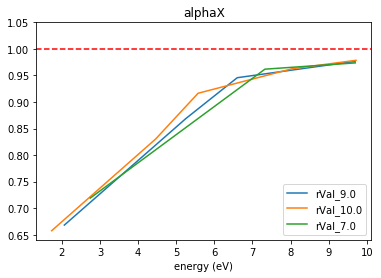

In [78]:
%matplotlib inline
component = 'alphaX'
for rVal in alpha_C6H6:
    val = np.array(alpha_C6H6[rVal][component])/C6H6_alpha_ref[component]
    plt.plot(alpha_C6H6[rVal]['naEnergy'],val,label='rVal_'+str(rVal))
plt.legend(loc='best')
plt.xlabel('energy (eV)')
plt.axhline(y=1.0, color='r', linestyle='--')
plt.title(component)
plt.ylim(ymax=1.05)
plt.show()

### Dynamical polarizability

In [79]:
reload(LR)
C6H6_spectrum = LR.collect_spectrum(C6H6)

Compute for rVal =  9.0  with nalpha =  169
numpoint =  227  omegaMax (eV) =  31.0166062508
Compute for rVal =  10.0  with nalpha =  220
numpoint =  228  omegaMax (eV) =  31.0830728297
Compute for rVal =  7.0  with nalpha =  94
numpoint =  228  omegaMax (eV) =  31.09085985


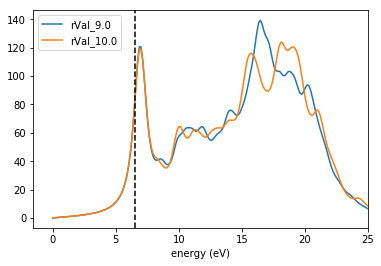

In [83]:
%matplotlib inline
syst = C6H6_spectrum
for rVal in [9.0,10.0]:#syst:
    plt.plot(syst[rVal]['omega'],syst[rVal]['imagPart'],label='rVal_'+str(rVal))
plt.xlim(xmax=25)
plt.legend(loc='best')
plt.xlabel('energy (eV)')
#plt.title('Absorption spectrum')
eps_h = abs(HaeV*LR.get_alpha_energy(C6H6[7.0]['logfile'],norbC6H6,0))
plt.axvline(x=eps_h, color='black', linestyle='--')
plt.show()

### Excitations

We add the threshold key to the dictionary (for the first numExc excitations)

In [84]:
reload(LR)
numExc = 1000 #2000
LR.collect_excitation_thr(C6H6,norbC6H6,numExc,tol=1e-1)

In [86]:
for rVal in C6H6:
    nalpha = C6H6[rVal]['eigenproblems'].keys()
    nalpha.sort()
    nvirt = nalpha[-1]
    maxEng = HaeV*np.sqrt(C6H6[rVal]['eigenproblems'][nvirt]['eigenvalues'][numExc-1]) 
    print 'maxEng for rval_', rVal, ' = ', maxEng

maxEng for rval_ 9.0  =  13.5074761597
maxEng for rval_ 10.0  =  12.8450322156
maxEng for rval_ 7.0  =  15.4923605166


We plot the excitations landscape in the different box

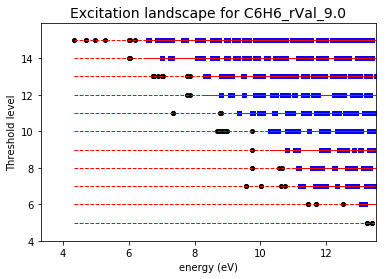

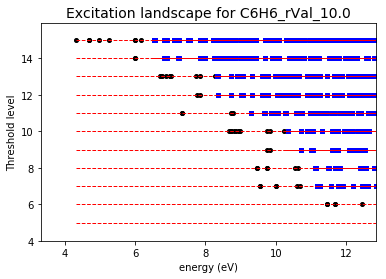

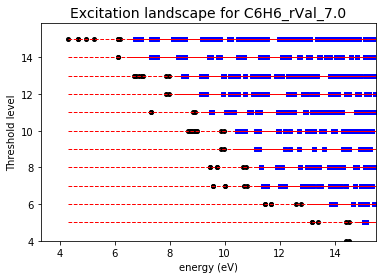

In [87]:
for rVal in C6H6:
    nalpha = C6H6[rVal]['eigenproblems'].keys()
    nalpha.sort()
    nvirt = nalpha[-1]
    syst = C6H6[rVal]['eigenproblems'][nvirt]
    pEng = LR.get_p_energy(C6H6[rVal]['logfile'],norbC6H6)

    Emin = HaeV*np.sqrt(syst['eigenvalues'][0])
    Emax = HaeV*np.sqrt(syst['eigenvalues'][numExc-1])

    for ind,p in enumerate(pEng):
        plt.plot((Emin,HaeV*abs(p)),(ind+1,ind+1),'--',c='red',linewidth=1)
        plt.plot((HaeV*abs(p),Emax),(ind+1,ind+1),'-',c='red',linewidth=1)
    
    for exc in range(numExc):
        eng = HaeV*np.sqrt(syst['eigenvalues'][exc])
        thind = syst['thresholds'][exc][0]
        th = HaeV*syst['thresholds'][exc][1]
        if eng < th : 
            plt.scatter(eng,thind,s=16,marker='o',c='black')
        else :
            plt.scatter(eng,thind,s=14,marker='s',c='blue')
    plt.title('Excitation landscape for C6H6_rVal_'+str(rVal),size=14) 
    plt.xlabel('energy (eV)')
    plt.ylabel('Threshold level')
    plt.ylim(ymin=4)
    plt.xlim(xmin=Emin-1,xmax=Emax)
    plt.show()

We plot the dos (of a given channel) comparing the results of different box

In [88]:
reload(LR)
channels = LR.collect_channels(C6H6,norbC6H6,numExc)

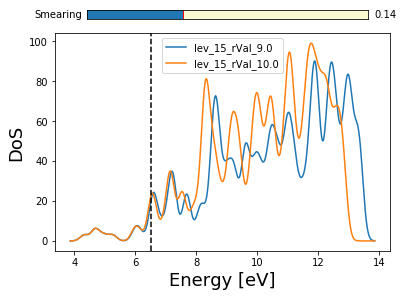

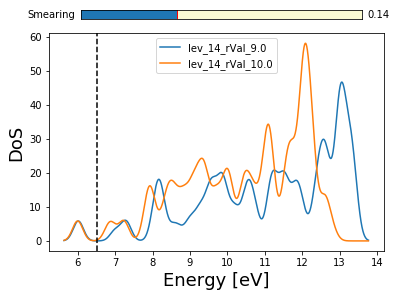

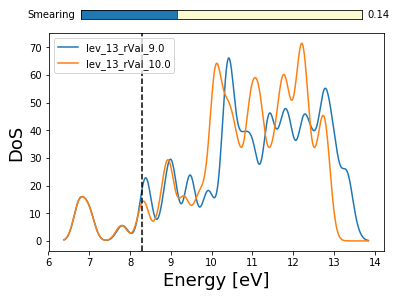

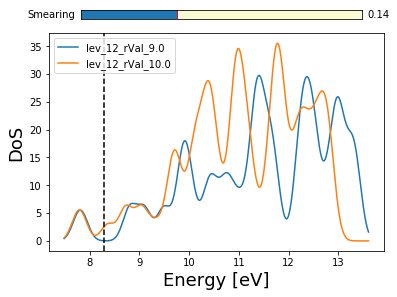

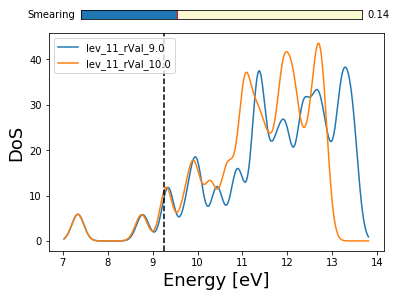

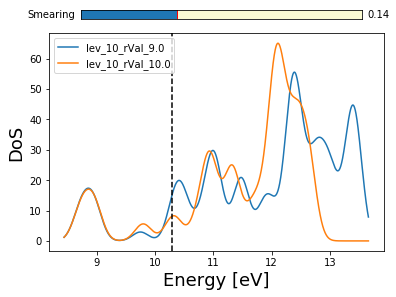

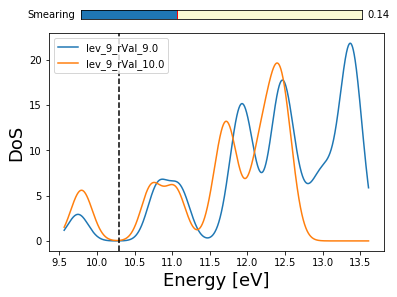

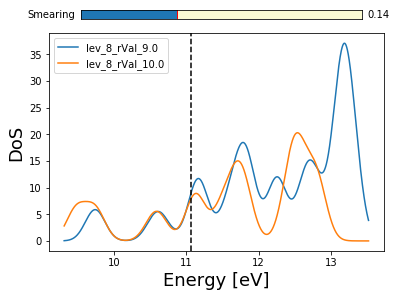

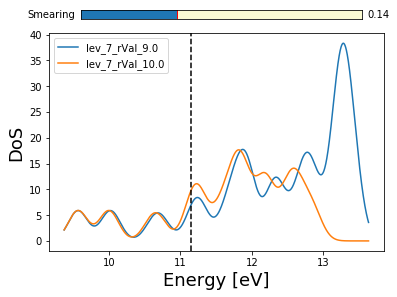

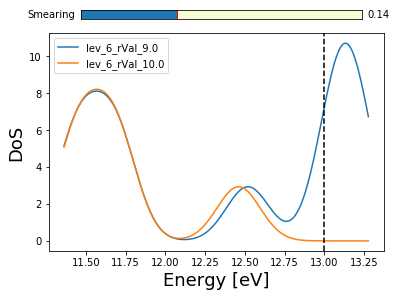

In [96]:
%matplotlib inline
levels = [15,14,13,12,11,10,9,8,7,6]
for l in levels:
    fe = HaeV*abs(LR.get_p_energy(C6H6[7.0]['logfile'],norbC6H6)[l-1])
    dos=D.DoS(fermi_level=fe)
    for rVal in [9.0,10.0]: #channels:
        dos.append(energies=np.array([channels[rVal][l-1]]),label='lev_'+str(l)+'_rVal_'+str(rVal))
    dos.plot(sigma=0.005*HaeV)

As a final analysis we repeat the calculation of dynamical polarizability separing the contributions due to excitations above and below threshold 

In [92]:
reload(LR)
C6H6_spectrum_bt,C6H6_spectrum_at = LR.collect_spectrum_bt_at(C6H6)

numpoint =  99  omegaMax (eV) =  13.5074761597
numpoint =  99  omegaMax (eV) =  13.5074761597
numpoint =  94  omegaMax (eV) =  12.8450322156
numpoint =  94  omegaMax (eV) =  12.8450322156
numpoint =  113  omegaMax (eV) =  15.4923605166
numpoint =  113  omegaMax (eV) =  15.4923605166


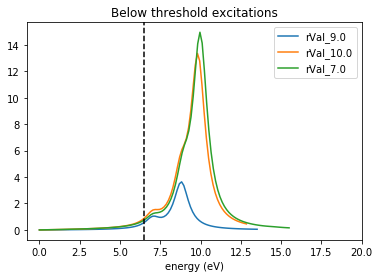

In [93]:
syst = C6H6_spectrum_bt
for rVal in syst:
    plt.plot(syst[rVal]['omega'],syst[rVal]['imagPart'],label='rVal_'+str(rVal))
plt.xlim(xmax=20)
plt.legend(loc='best')
plt.xlabel('energy (eV)')
plt.title('Below threshold excitations')
eps_h = abs(HaeV*LR.get_alpha_energy(C6H6[7.0]['logfile'],norbC6H6,0))
plt.axvline(x=eps_h, color='black', linestyle='--')
plt.show()

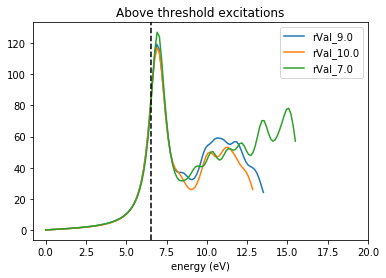

In [94]:
%matplotlib inline
syst = C6H6_spectrum_at
for rVal in syst:
    plt.plot(syst[rVal]['omega'],syst[rVal]['imagPart'],label='rVal_'+str(rVal))
plt.xlim(xmax=20)
plt.legend(loc='best')
plt.xlabel('energy (eV)')
plt.title('Above threshold excitations')
eps_h = abs(HaeV*LR.get_alpha_energy(C6H6[7.0]['logfile'],norbC6H6,0))
plt.axvline(x=eps_h, color='black', linestyle='--')
plt.show()

In [95]:
rVal= 7.0
syst = C6H6[rVal]['eigenproblems']
nalpha = syst.keys()
nalpha.sort()
nvirt = nalpha[-1]

for exc in range(50):

    pProj = LR.identify_contributions(norbC6H6,nvirt,exc,syst[nvirt]['eigenvectors'])
    out = pProj[0:norbC6H6] + pProj[norbC6H6:2*norbC6H6]
    for ind,o in enumerate(out):
        if o<1e-2: 
            out[ind] = 0.0
    som = 0
    for o in out: som+=o
    print out, som, HaeV*np.sqrt(syst[nvirt]['eigenvalues'][exc]),syst[nvirt]['oscillator_strength_avg'][exc] 

[ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.49712525  0.49740396] 0.99452920596 4.32413319159 6.73104214945e-32
[ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.49964347  0.49989431] 0.999537778037 4.68670603141 1.863713873e-30
[ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.49944749  0.50008986] 0.999537351821 4.68672468612 8.7740499286e-31
[ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.50054022  0.49936975] 0.999909965671 4.9653974086 3.98111204512e-31
[ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0